0.265625
0.296875
-----------------------------------
0.546875
0.5625
-----------------------------------
0.53125
0.5625
-----------------------------------
0.515625
0.5625
-----------------------------------
0.546875
0.5625
-----------------------------------
0.59375
0.5625
-----------------------------------
0.515625
0.578125
-----------------------------------
0.421875
0.5625
-----------------------------------
0.515625
0.578125
-----------------------------------
0.515625
0.5625
-----------------------------------
0.390625
0.578125
-----------------------------------
0.4375
0.375
-----------------------------------
0.375
0.296875
-----------------------------------
0.484375
0.46875
-----------------------------------


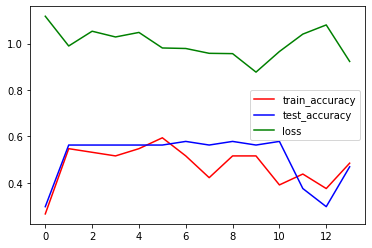

'\n    batch_xs, batch_ys = sess.run(train_next_element)\n    # batch_xs = np.reshape(batch_xs, [batch_size, img_size * img_size * channel])\n    print(batch_xs.shape, batch_ys.shape)\n'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import lists

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline

batch_size = 64
img_size = 128
channel = 1
classes = 3

# shape形式：[batch, height, width, channels]
# 定义weight
def weight_variable(shape):
    # 初始值：从截断的正态分布中输出随机值（方差为0.1）
    # 使用truncated_normal时，如果x的取值在（μ-2σ，μ+2σ）之外则重新生成
    # truncated_normal保证了生成的值都在均值附近
    # random_normal则是完全随机
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)


# 定义bias
def bias_varibale(shape):
    # 通常为正值
    initial = tf.constant(0.05, shape=[shape])
    return tf.Variable(initial)


# 定义CNN层，作用为提取图片特征
def conv2d(x, W):
    # strides 步长，每个几个pixel采样
    # strides 固定格式：[1, x_movement, y_movement， 1]
    # padding SAME包括图片外面一点，用0填充；VALID则是全部在图片里
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# 定义pooling层，作用为减小strides的影响，保留更多图片特征
def max_pool_2x2(x):
    # kszie 池化窗口大小 一般是[1, height, width, 1]
    # strides设置为2，更好地压缩图片
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')


def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):
    # We shall define the weights that will be trained using create_weights function.
    weights = weight_variable(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    # We create biases using the create_biases function. These are also trained.
    biases = bias_varibale(num_filters)

    # Creating the convolutional layer
    layer = conv2d(input, weights)
    layer += biases
    # We shall be using max-pooling.
    layer = max_pool_2x2(layer)
    # Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer


def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    # Let's define trainable weights and biases.
    weights = weight_variable(shape=[num_inputs, num_outputs])
    biases = bias_varibale(num_outputs)

    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


# define variables and placeholders
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, channel], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32)

# build network
filter_size = 3
num_filters = 32

layer_conv1 = create_convolutional_layer(input=x,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=num_filters)

layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=num_filters)

layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=2*num_filters)

layer_flat = create_flatten_layer(layer_conv3)

num_outputs = 64

layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=num_outputs,
                            use_relu=True)

layer_fc1_drop = tf.nn.dropout(layer_fc1, keep_prob=0.7)

layer_fc2 = create_fc_layer(input=layer_fc1_drop,
                            num_inputs=num_outputs,
                            num_outputs=num_outputs*2,
                            use_relu=True)

layer_fc2_drop = tf.nn.dropout(layer_fc2, keep_prob=0.7)

layer_fc3 = create_fc_layer(input=layer_fc2_drop,
                           num_inputs=num_outputs*2,
                           num_outputs=classes,
                           use_relu=False)

y_pred = tf.nn.softmax(layer_fc3, name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_emtropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(cross_emtropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_pred = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_emtropy)

init = tf.global_variables_initializer()

# get datasets from lists.py
datasets = lists.init(batch_size)

# 创建迭代器用于传送数据
train_iterator = tf.compat.v1.data.make_initializable_iterator(datasets.train_dataset)
train_next_element = train_iterator.get_next()

test_iterator = tf.compat.v1.data.make_initializable_iterator(datasets.test_dataset)
test_next_element = test_iterator.get_next()

# 定义训练参数
train_times = 700
output_gap = 50

train_acc = []
test_acc = []
loss_test = []

with tf.Session() as sess:
    sess.run(init)
    # sess.run(tf.local_variables_initializer())
    sess.run(train_iterator.initializer)
    sess.run(test_iterator.initializer)
    
    batch_xs_test, batch_ys_test = sess.run(test_next_element)

    for i in range(train_times):
        # 设定一次训练的数据量batch
        # batch_xs.shape = (batch_size, img_w, img_h, 1), batch_ys.shape = (batch_size,3)
        batch_xs, batch_ys = sess.run(train_next_element)
        
        sess.run(optimizer, feed_dict={x: batch_xs, y_true: batch_ys})
        if i % output_gap == 0:
            # shuffle test data
            indices = np.random.permutation(batch_xs_test.shape[0]) # shape[0]表示第0轴的长度，通常是训练数据的数量
            rand_batch_xs_test = batch_xs_test[indices]
            rand_batch_ys_test = batch_ys_test[indices]
            
            train_now = sess.run(accuracy, feed_dict={x: batch_xs, y_true: batch_ys})
            test_now = sess.run(accuracy, feed_dict={x: rand_batch_xs_test, y_true: rand_batch_ys_test})
            loss = sess.run(cost, feed_dict={x: batch_xs_test, y_true: batch_ys_test})
            
            train_acc.append(train_now)
            test_acc.append(test_now)
            loss_test.append(loss)
            print(train_now)
            print(test_now)
            print('-----------------------------------')


# 可视化
x_range = (int)(train_times / output_gap)
x = range(0, x_range)

plt.plot(x, train_acc, color='red', label='train_accuracy')
plt.plot(x, test_acc, color='blue', label='test_accuracy')
plt.plot(x, loss_test, color='green', label='loss')
plt.legend()
plt.show()
'''
    batch_xs, batch_ys = sess.run(train_next_element)
    # batch_xs = np.reshape(batch_xs, [batch_size, img_size * img_size * channel])
    print(batch_xs.shape, batch_ys.shape)
'''


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import lists

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline

batch_size = 64
img_size = 128
channel = 1
classes = 3

# shape形式：[batch, height, width, channels]
# 定义weight
def weight_variable(shape):
    # 初始值：从截断的正态分布中输出随机值（方差为0.1）
    # 使用truncated_normal时，如果x的取值在（μ-2σ，μ+2σ）之外则重新生成
    # truncated_normal保证了生成的值都在均值附近
    # random_normal则是完全随机
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)


# 定义bias
def bias_varibale(shape):
    # 通常为正值
    initial = tf.constant(0.05, shape=[shape])
    return tf.Variable(initial)


# 定义CNN层，作用为提取图片特征
def conv2d(x, W):
    # strides 步长，每个几个pixel采样
    # strides 固定格式：[1, x_movement, y_movement， 1]
    # padding SAME包括图片外面一点，用0填充；VALID则是全部在图片里
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# 定义pooling层，作用为减小strides的影响，保留更多图片特征
def max_pool_2x2(x):
    # kszie 池化窗口大小 一般是[1, height, width, 1]
    # strides设置为2，更好地压缩图片
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')


def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):
    # We shall define the weights that will be trained using create_weights function.
    weights = weight_variable(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    # We create biases using the create_biases function. These are also trained.
    biases = bias_varibale(num_filters)

    # Creating the convolutional layer
    layer = conv2d(input, weights)
    layer += biases
    # We shall be using max-pooling.
    layer = max_pool_2x2(layer)
    # Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer


def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    # Let's define trainable weights and biases.
    weights = weight_variable(shape=[num_inputs, num_outputs])
    biases = bias_varibale(num_outputs)

    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


# define variables and placeholders
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, channel], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32)

# build network
filter_size = 3
num_filters = 32

layer_conv1 = create_convolutional_layer(input=x,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=num_filters)

layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=num_filters)

layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                         num_input_channels=channel,
                                         conv_filter_size=filter_size,
                                         num_filters=2*num_filters)

layer_flat = create_flatten_layer(layer_conv3)

num_outputs = 64

layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=num_outputs,
                            use_relu=True)

layer_fc1_drop = tf.nn.dropout(layer_fc1, keep_prob=0.7)

layer_fc2 = create_fc_layer(input=layer_fc1_drop,
                            num_inputs=num_outputs,
                            num_outputs=num_outputs*2,
                            use_relu=True)

layer_fc2_drop = tf.nn.dropout(layer_fc2, keep_prob=0.7)

layer_fc3 = create_fc_layer(input=layer_fc2_drop,
                           num_inputs=num_outputs*2,
                           num_outputs=classes,
                           use_relu=False)

y_pred = tf.nn.softmax(layer_fc3, name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_emtropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(cross_emtropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_pred = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_emtropy)

init = tf.global_variables_initializer()

# get datasets from lists.py
datasets = lists.init(batch_size)

# 创建迭代器用于传送数据
train_iterator = tf.compat.v1.data.make_initializable_iterator(datasets.train_dataset)
train_next_element = train_iterator.get_next()

test_iterator = tf.compat.v1.data.make_initializable_iterator(datasets.test_dataset)
test_next_element = test_iterator.get_next()

# 定义训练参数
train_times = 50
output_gap = 50

train_acc = []
test_acc = []
loss_test = []

with tf.Session() as sess:
    sess.run(init)
    # sess.run(tf.local_variables_initializer())
    sess.run(train_iterator.initializer)
    sess.run(test_iterator.initializer)
    
    batch_xs_test, batch_ys_test = sess.run(test_next_element)

    for i in range(train_times):
        # 设定一次训练的数据量batch
        # batch_xs.shape = (batch_size, img_w, img_h, 1), batch_ys.shape = (batch_size,3)
        batch_xs, batch_ys = sess.run(train_next_element)
        
        ###permutation可行 接下来就是实现在测试数据打包前suffle、测试数据每次suffle
        indices = np.random.permutation(batch_xs.shape[0]) # shape[0]表示第0轴的长度，通常是训练数据的数量
        rand_batch_xs = batch_xs[indices]
        rand_batch_ys = batch_ys[indices]
        
        print(rand_batch_xs[5], rand_batch_ys[5])
        print(type(rand_batch_xs), type(rand_batch_ys))
        
        if i % output_gap == 0:
            
            
            print('-----------------------------------')

'''
    batch_xs, batch_ys = sess.run(train_next_element)
    # batch_xs = np.reshape(batch_xs, [batch_size, img_size * img_size * channel])
    print(batch_xs.shape, batch_ys.shape)
'''


[[[0.       ]
  [0.953125 ]
  [0.       ]
  ...
  [0.       ]
  [0.       ]
  [3.8125   ]]

 [[0.5      ]
  [0.5      ]
  [0.       ]
  ...
  [0.       ]
  [0.       ]
  [2.3828125]]

 [[1.       ]
  [0.       ]
  [0.375    ]
  ...
  [2.28125  ]
  [0.       ]
  [0.953125 ]]

 ...

 [[3.5      ]
  [1.5234375]
  [1.90625  ]
  ...
  [2.1328125]
  [0.046875 ]
  [0.       ]]

 [[4.       ]
  [2.       ]
  [1.90625  ]
  ...
  [3.5625   ]
  [0.       ]
  [0.       ]]

 [[1.       ]
  [1.953125 ]
  [2.       ]
  ...
  [3.859375 ]
  [0.09375  ]
  [0.       ]]] [0 0 1]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-----------------------------------
[[[253.      ]
  [221.      ]
  [243.      ]
  ...
  [ 58.      ]
  [ 60.      ]
  [ 62.      ]]

 [[163.98438 ]
  [118.11328 ]
  [ 92.03906 ]
  ...
  [ 41.945312]
  [ 42.054688]
  [ 40.164062]]

 [[126.421875]
  [ 92.11719 ]
  [ 69.75    ]
  ...
  [ 27.164062]
  [ 23.65625 ]
  [ 19.367188]]

 ...

 [[ 28.      ]
  [ 24.582031]
  [ 29.492188]
  ...

[[[ 90.      ]
  [100.5     ]
  [ 61.      ]
  ...
  [115.5     ]
  [ 93.      ]
  [ 88.      ]]

 [[106.75    ]
  [ 38.40625 ]
  [ 29.      ]
  ...
  [ 30.078125]
  [ 35.09375 ]
  [ 37.203125]]

 [[ 53.625   ]
  [ 28.71875 ]
  [ 21.625   ]
  ...
  [ 14.75    ]
  [ 19.125   ]
  [ 25.25    ]]

 ...

 [[ 98.125   ]
  [ 71.078125]
  [ 69.0625  ]
  ...
  [ 16.015625]
  [ 19.03125 ]
  [ 24.015625]]

 [[108.75    ]
  [ 83.125   ]
  [ 78.4375  ]
  ...
  [ 16.5     ]
  [ 20.      ]
  [ 25.34375 ]]

 [[142.28125 ]
  [102.453125]
  [ 93.      ]
  ...
  [ 16.5     ]
  [ 21.34375 ]
  [ 27.015625]]] [0 1 0]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[[0.0000000e+00]
  [6.7046875e+01]
  [7.3093750e+01]
  ...
  [1.4062500e-01]
  [2.7187500e+00]
  [2.4467188e+02]]

 [[1.0000000e+00]
  [6.9640625e+01]
  [1.3678125e+02]
  ...
  [2.1093750e-01]
  [1.4062500e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [6.6328125e+01]
  [7.2656250e+01]
  ...
  [0.0000000e+00]
  [9.3750000e-02]
  [3.9531250e+00]]

 .

[[[ 53.  ]
  [ 51.5 ]
  [ 40.  ]
  ...
  [  9.5 ]
  [  8.  ]
  [  8.  ]]

 [[ 57.5 ]
  [ 27.25]
  [  1.5 ]
  ...
  [  1.5 ]
  [  1.5 ]
  [  1.5 ]]

 [[ 64.  ]
  [  3.5 ]
  [  0.  ]
  ...
  [  1.  ]
  [  1.  ]
  [  1.  ]]

 ...

 [[255.  ]
  [248.5 ]
  [227.  ]
  ...
  [224.5 ]
  [209.5 ]
  [209.  ]]

 [[255.  ]
  [250.5 ]
  [219.  ]
  ...
  [245.5 ]
  [229.  ]
  [214.  ]]

 [[254.  ]
  [252.5 ]
  [237.5 ]
  ...
  [239.  ]
  [226.5 ]
  [207.  ]]] [0 1 0]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[[  8.       ]
  [  8.       ]
  [  7.       ]
  ...
  [ 44.734375 ]
  [237.15625  ]
  [253.04688  ]]

 [[  8.       ]
  [  7.5      ]
  [  8.       ]
  ...
  [ 49.296875 ]
  [239.53125  ]
  [253.04688  ]]

 [[  8.       ]
  [  7.953125 ]
  [  8.       ]
  ...
  [ 68.734375 ]
  [240.875    ]
  [253.04688  ]]

 ...

 [[  7.5      ]
  [  5.6171875]
  [  7.859375 ]
  ...
  [ 50.578125 ]
  [100.6875   ]
  [230.64062  ]]

 [[  7.       ]
  [  8.90625  ]
  [  7.1875   ]
  ...
  [ 61.5625   ]
  

[[[246.       ]
  [225.       ]
  [205.       ]
  ...
  [  0.       ]
  [  7.       ]
  [ 35.5      ]]

 [[234.14844  ]
  [219.03906  ]
  [192.75781  ]
  ...
  [  5.8046875]
  [ 17.195312 ]
  [ 32.390625 ]]

 [[181.34375  ]
  [100.41406  ]
  [ 86.6875   ]
  ...
  [  8.3046875]
  [ 18.390625 ]
  [ 30.085938 ]]

 ...

 [[207.10156  ]
  [ 91.75781  ]
  [ 56.484375 ]
  ...
  [  6.4140625]
  [ 12.4140625]
  [ 21.207031 ]]

 [[203.4375   ]
  [ 97.91406  ]
  [ 56.609375 ]
  ...
  [  5.8046875]
  [ 12.609375 ]
  [ 21.5      ]]

 [[221.39062  ]
  [102.40234  ]
  [ 58.78125  ]
  ...
  [  1.609375 ]
  [ 10.21875  ]
  [ 23.707031 ]]] [0 0 1]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]] [0 1 0]


'\n    batch_xs, batch_ys = sess.run(train_next_element)\n    # batch_xs = np.reshape(batch_xs, [batch_size, img_size * img_size * channel])\n    print(batch_xs.shape, batch_ys.shape)\n'